In [24]:
import nibabel as nib
import numpy as np

In [25]:
image_paths = ["data/images_liver.nii.gz", "data/images_spine.nii.gz"]
cm_paths = {
    "all": ["data/CMS/cms_all_liver.nii.gz", "data/CMS/cms_all_spine.nii.gz"],
    "mid": ["data/CMS/cms_mid_liver.nii.gz", "data/CMS/cms_mid_spine.nii.gz"],
    "min": ["data/CMS/cms_min_liver.nii.gz", "data/CMS/cms_min_spine.nii.gz"],
    "ultranerf": ["data/CMS/cms_ultranerf_liver.nii.gz", "data/CMS/cms_ultranerf_spine.nii.gz"],
    "acyclic": ["data/CMS/cms_acyclic_liver.nii.gz", "data/CMS/cms_acyclic_spine.nii.gz"],
}

In [52]:
# Load images
images = []
for image_path in image_paths:
    images.append(nib.load(image_path).get_fdata())

# Load cms
cms = {}

for key, paths in cm_paths.items():
    cms[key] = []
    for path in paths:
        cm = nib.load(path).get_fdata()

        # Normalize
        cm = cm - np.mean(cm)
        cm = cm / np.std(cm)

        # cm = cm - np.min(cm)
        # cm = cm / np.max(cm)

        cms[key].append(cm)


In [53]:
# Print shapes of all
for key, cm in cms.items():
    print(key)
    for i in range(len(cm)):
        print(cm[i].shape)
    print()

all
(200, 512, 256)
(152, 1300, 164)

mid
(200, 512, 256)
(152, 1300, 164)

min
(200, 512, 256)
(152, 1300, 164)

ultranerf
(200, 512, 256)
(152, 1300, 164)

acyclic
(200, 512, 256)
(152, 1300, 164)



In [54]:
# Calculate 0-value errors


for data_idx, image in enumerate(images):

    zero_mask = image < 10

    for key, cm in cms.items():

        curr_cm = cm[data_idx]

        mean = curr_cm[zero_mask].mean()
        std = curr_cm[zero_mask].std()

        data_name = "liver" if data_idx == 0 else "spine"

        print(f"Data: {data_name}, Confidence Map: {key}, Mean: {mean}, Std: {std}")
    print()

Data: liver, Confidence Map: all, Mean: -1.6778474713644558, Std: 2.9836466769987284
Data: liver, Confidence Map: mid, Mean: -1.7761259804520424, Std: 3.1865416313383284
Data: liver, Confidence Map: min, Mean: -1.6793170250812561, Std: 2.985613129174279
Data: liver, Confidence Map: ultranerf, Mean: 0.6169145194160454, Std: 2.1368235220903404
Data: liver, Confidence Map: acyclic, Mean: 1.0470731748327282, Std: 1.7716816495564747

Data: spine, Confidence Map: all, Mean: -0.0013769839798483505, Std: 1.0088208087666068
Data: spine, Confidence Map: mid, Mean: 0.0006255083917988734, Std: 1.0072223226931376
Data: spine, Confidence Map: min, Mean: -0.0013575705521186958, Std: 1.008806437925811
Data: spine, Confidence Map: ultranerf, Mean: 0.011733429181579694, Std: 1.003744961657238
Data: spine, Confidence Map: acyclic, Mean: 0.008352338295065044, Std: 1.0104311934614079



Liver Label Shape: (200, 512, 256)


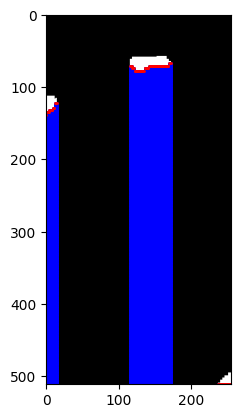

In [55]:
# Load Liver Labels

label_path = "data/liver_labels/l1.nii"
liver_label = nib.load(label_path).get_fdata()[..., 0, :]

# Correct the orientation of the images
liver_label = np.transpose(liver_label, (2, 0, 1))
liver_label = np.transpose(liver_label, (0, 2, 1))

# Crop the extra pixels
liver_label = liver_label[:, :-4, :]
print(f"Liver Label Shape: {liver_label.shape}")

liver_bone_mask = liver_label == 13

# Coordinates
liver_bone_coords = np.where(liver_bone_mask)

bone_bottoms = []
shadow_mask = np.zeros(liver_bone_mask.shape, dtype=bool)

for i in range(liver_bone_mask.shape[0]):
    for j in range(liver_bone_mask.shape[2]):
        line = liver_bone_mask[i, :, j]
        if np.any(line):
            bottom = np.where(line)[0][-1]
            bone_bottoms.append((i, bottom, j))
            shadow_mask[i, bottom:, j] = 1

bone_bottoms = np.array(bone_bottoms)


# Plot the bone bottoms on labels
import matplotlib.pyplot as plt

slice = 54
plt.imshow(liver_bone_mask[slice, :, :], cmap="gray")
plt.scatter(np.where(shadow_mask[slice])[1], np.where(shadow_mask[slice])[0], c="b", s=1)
plt.scatter(bone_bottoms[ bone_bottoms[:, 0] == slice, 2], bone_bottoms[ bone_bottoms[:, 0] == slice, 1], c="r", s=1)

plt.show()

In [56]:
# Calculate the mean and std of the confidence maps

for key, cm in cms.items():
    
        curr_cm = cm[0]

        mean = curr_cm[shadow_mask].mean()
        std = curr_cm[shadow_mask].std()

        print(f"Data Liver, Confidence Map: {key}, Mean: {mean}, Std: {std}")
print()

Data Liver, Confidence Map: all, Mean: -0.16931338710693558, Std: 1.2082084740088548
Data Liver, Confidence Map: mid, Mean: -0.16471339459498713, Std: 1.1890342578452449
Data Liver, Confidence Map: min, Mean: -0.16916493467785398, Std: 1.207914166289203
Data Liver, Confidence Map: ultranerf, Mean: -1.1409649285986119, Std: 0.4700301815857014
Data Liver, Confidence Map: acyclic, Mean: -0.6206757556369878, Std: 0.5951748792683769



In [57]:
# Print min and max of the confidence maps

for key, cm in cms.items():
        
        curr_cm = cm[0]

        min = curr_cm.min()
        max = curr_cm.max()

        print(f"Data Liver, Confidence Map: {key}, Min: {min}, Max: {max}")

Data Liver, Confidence Map: all, Min: -6.822958641499335, Max: 1.3684999181580377
Data Liver, Confidence Map: mid, Min: -7.49636304582791, Max: 1.4679357688143235
Data Liver, Confidence Map: min, Min: -6.828717096392547, Max: 1.2083779640197219
Data Liver, Confidence Map: ultranerf, Min: -2.1695016163620267, Max: 2.5222041566240714
Data Liver, Confidence Map: acyclic, Min: -1.4604808495118906, Max: 2.7671072760799453
